In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import scipy.stats as stats
from tkinter import Tk

In [3]:
from tkinter.filedialog import askopenfilename

Tk().withdraw()

username = input("user identity (this string will be named in front of every graph picture):")
datafile = askopenfilename(title="Choose the data file from the experiment, TH file")
thai_mainflow = pd.read_csv(datafile)
datafile = askopenfilename(title="Choose the data file from the experiment, EN file")
english_mainflow = pd.read_csv(datafile)


english_words = pd.read_excel("./isitword test/ref/wordorderen_full.xlsx")
thai_words = pd.read_excel("./isitword test/ref/wordorderth_full.xlsx")

# SCORE CALCULATION

In [4]:
# Score calculation function
def calculate_score(df):
    conditions = [
        (df['key_resp.keys'] == 'z') & (df['stimuli'] == 1),
        (df['key_resp.keys'] == 'x') & (df['stimuli'].isin([2, 3]))
    ]
    values = [1, 1]
    df['score'] = np.select(conditions, values, default=0)
    return df

def cutdf(prepdf):
    cutdf = prepdf.iloc[1:121][["lang","imageid","stimuli","key_resp.keys","key_resp.rt"]].reset_index(drop=True)
    return cutdf

# Apply score calculation
english_mainflow = calculate_score(cutdf(english_mainflow))
thai_mainflow = calculate_score(cutdf(thai_mainflow))

# WORD LENGTH

In [5]:
# Word length calculation function
def get_word_length(df, words_df, lang):
    word_length_dict = words_df.set_index('imageid')['word shown'].astype(str).apply(len).to_dict()
    df['word_length'] = df['imageid'].map(word_length_dict)
    return df

english_mainflow = get_word_length(english_mainflow, english_words, 'English')
thai_mainflow = get_word_length(thai_mainflow, thai_words, 'Thai')

# CHANGE STIMULI

In [6]:
def convert_stimuli(df):
    stimuli_map = {1: 'Correct', 2: 'Scramble', 3: 'Typo'}
    df['stimuli'] = df['stimuli'].map(stimuli_map)
    return df

# Apply Stimuli Conversion
english_mainflow = convert_stimuli(english_mainflow)
thai_mainflow = convert_stimuli(thai_mainflow)

# Remove Pear Hose Drill Couch

In [35]:
# List of words to exclude
exclude_words = ["pear", "hose", "drill", "couch"]

# Filter English mainflow dataset
english_mainflow = english_mainflow[~english_mainflow['imageid'].isin(english_words[english_words['word shown'].isin(exclude_words)]['imageid'])]

In [36]:
# Combine data for analysis
english_mainflow['Language'] = 'English'
thai_mainflow['Language'] = 'Thai'
data = pd.concat([english_mainflow, thai_mainflow])


# Function to plot graphs
def save_plot(title):
    file_path = f"./figure/{username} II {title}.png"
    plt.savefig(file_path, dpi=300, bbox_inches='tight')

Calculate React time

In [37]:
# Reaction time analysis
reaction_time_means = data.groupby('Language')['key_resp.rt'].mean()
reaction_time_sems = data.groupby('Language')['key_resp.rt'].sem()

# Coloring factor

In [34]:
redgradient = ["#ffa5bb","#ff9eb6", "#ff7d9d", "#ff6087","#ff0040" ] # thai language, use the last index value as the main color
bluegradient = ["#c0d7ff", "#92bcff", "#5e9eff","#3686ff","#0067ff" ] # english language, use the last index value as the main color
gaygradient = ["#949494", '#727272', '#4b4b4b', '#484848', '#373737'] # overall gradient
colincorrect = '#ff6962'
colcorrect  = '#77dd76'

# ALL CODES BELOW GENERATE GRAPH

%correct vs lang

Language
Thai       94.166667
English    88.288288
Name: score, dtype: float64 <class 'pandas.core.series.Series'>


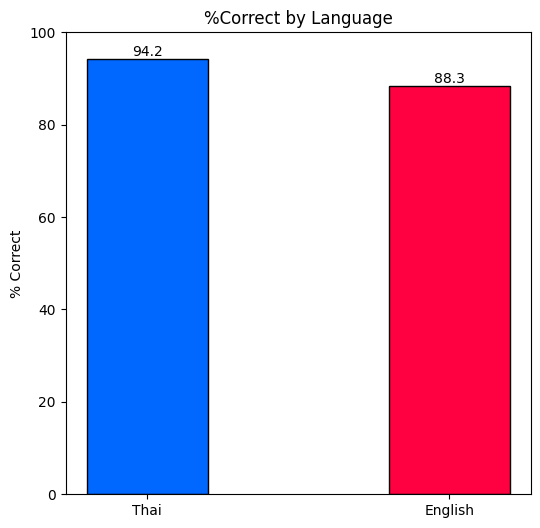

In [275]:
# Plot percentage correct per language
custom_order = ['Thai', 'English']
correct_rates = data.groupby('Language')['score'].mean().reindex(custom_order) * 100
print(correct_rates, type(correct_rates))
plt.figure(figsize=(6, 6))
plt.bar(correct_rates.index, correct_rates.values, color=[bluegradient[4], redgradient[4]], edgecolor = 'black', width=0.4)
plt.ylabel("% Correct")
plt.yticks(np.arange(0,101, 20))
plt.title("%Correct by Language")
for x, y in zip(correct_rates.index, correct_rates.values):
    plt.text(x, y, f'{y:.1f}', ha='center', va='bottom', fontsize=10)

save_plot("percentage correct by language")

%correct vs length

word_length
3    91.666667
4    97.619048
5    92.156863
6    87.500000
7    88.888889
Name: score, dtype: float64


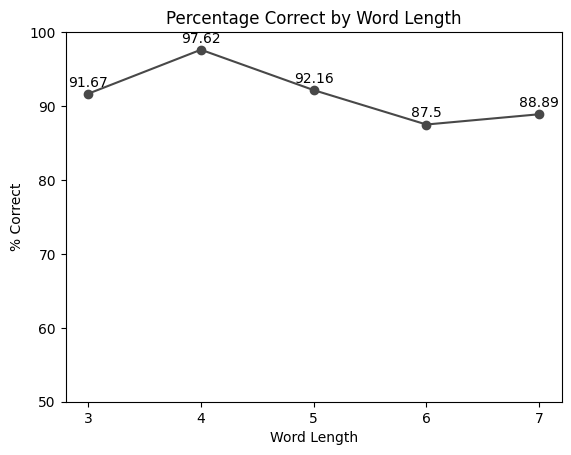

In [276]:
# Word length vs % correct


proportion_df = data.groupby('word_length')['score'].mean() * 100
print(proportion_df)
x = proportion_df.index
y = proportion_df.values

plt.plot(x, y, color = gaygradient[3], marker =  'o')
for i in range(len(x)):
    plt.text(x[i], y[i]+1, round(y[i], 2), ha = 'center')

# Labels and title
plt.ylabel("% Correct")
plt.xlabel("Word Length")
plt.title("Percentage Correct by Word Length")

plt.yticks(np.arange(50,101,10))
plt.xticks(x)

# Save plot
save_plot("percentage correct by word length")


Language        English       Thai
word_length                       
3             95.833333  83.333333
4            100.000000  95.238095
5             83.333333  96.969697
6             83.333333  91.666667
7             79.166667  96.666667


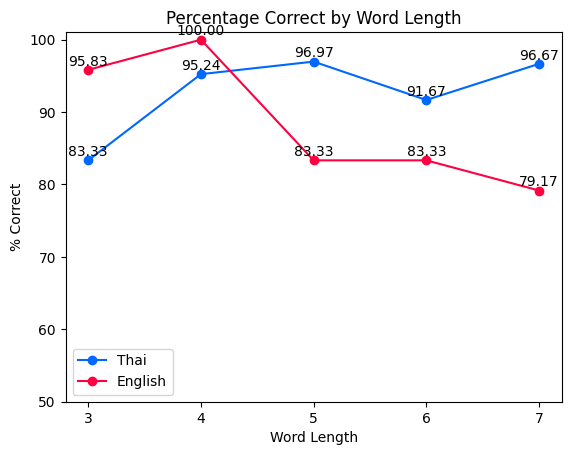

In [277]:

plot_data = data.groupby(['word_length', 'Language'], observed=True)['score'].mean().mul(100).unstack()
print(plot_data)
customorder = ['Thai', 'English']
plot_data = plot_data.reindex(columns=[col for col in customorder if col in plot_data.columns])

for lang, sublist in plot_data.items():
    x = sublist.index
    y = sublist.values
    colbylang = bluegradient[4] if lang == 'Thai' else redgradient[4] if lang == "English" else gaygradient[4]

    plt.plot(x, y, color = colbylang, marker = 'o', label = lang)

    for x, y in zip(x, y):
        plt.text(x, y +0.2, f'{y:.2f}', ha='center', va='bottom', fontsize=10)

plt.ylabel("% Correct")
plt.xlabel("Word Length")
plt.title("Percentage Correct by Word Length")
plt.legend()
plt.yticks(np.arange(50,101,10))
plt.xticks(plot_data.index)

save_plot("percentage correct by word length by language")


%correct vs stimuli

Language   Thai    English
stimuli                   
Correct    92.5  72.972973
Scramble  100.0  97.297297
Typo       90.0  94.594595 <class 'pandas.core.frame.DataFrame'>


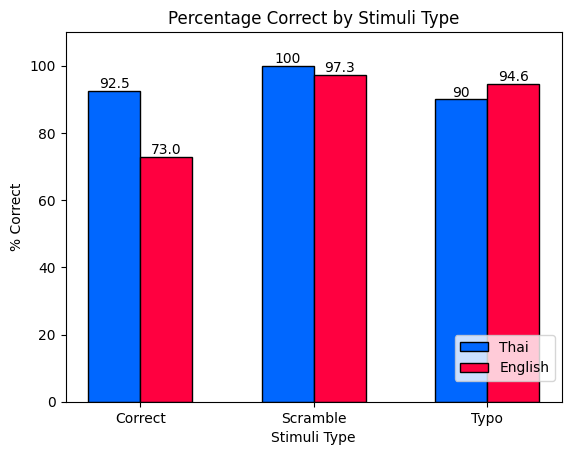

In [278]:
# Stimuli vs % correct
fig, ax = plt.subplots()
data['scorepercent'] = data['score'] * 100
plot_data = data.groupby(['stimuli', 'Language'], observed=True)['score'].mean().mul(100).unstack()

custom_order = ['Thai', 'English']
plot_data = plot_data.reindex(columns=[col for col in custom_order if col in plot_data.columns])

print(plot_data, type(plot_data))

for i, (lang, sublist) in enumerate(plot_data.items()):
    x = sublist.index
    y = sublist.values
    colbylang = bluegradient[4] if lang == 'Thai' else redgradient[4] if lang == "English" else gaygradient[4]
    width = 0.3

    plt.bar(np.arange(len(x)) + (i - 0.5) * width, y, width = width, color = colbylang, edgecolor = 'black',label = lang)

for p in ax.patches:
    height = p.get_height()
    if height > 0:
        label = f'{int(height)}' if height.is_integer() else f'{height:.1f}'
        ax.text(p.get_x() + p.get_width() / 2, height, label, ha='center', va='bottom')

# Labels and title
ax.set_ylabel("% Correct")
ax.set_xlabel("Stimuli Type")
ax.set_xticks(np.arange(0,len(plot_data.index),1))
ax.set_xticklabels(plot_data.index.tolist())
ax.set_title("Percentage Correct by Stimuli Type")

# Adjust legend position
ax.legend(loc='upper right', bbox_to_anchor=(1, 0.2))

# Set y-axis limits
ax.set_ylim(0, 110)

# Save plot
save_plot("percentage correct by stimuli")


# Reactime vs lang

In [279]:
# filter onlt correct reaction time
datafilter = data[data['score'] == 1]


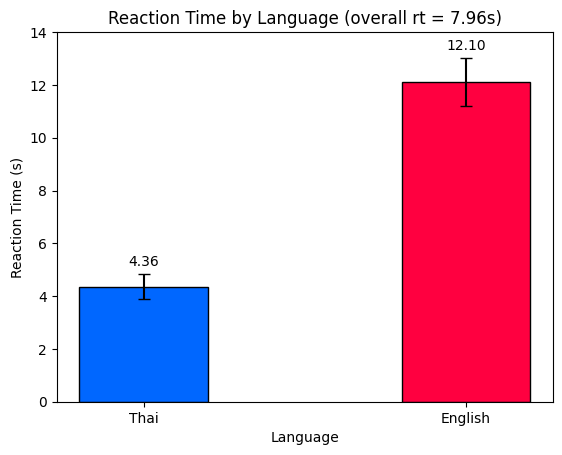

In [280]:
fig, ax = plt.subplots()
rtmeans = datafilter.groupby('Language')['key_resp.rt'].mean().reindex(['Thai', 'English'])
rtmeanall = datafilter['key_resp.rt'].mean()

rterr = datafilter.groupby('Language')['key_resp.rt'].sem().reindex(['Thai', 'English'])

plt.bar(rtmeans.index, rtmeans, yerr = rterr, color = [bluegradient[4], redgradient[4]], capsize = 4, width = 0.4, edgecolor = 'black')

plt.ylabel("Reaction Time (s)")
plt.title(f"Reaction Time by Language (overall rt = {round(rtmeanall,2)}s)" )
plt.xlabel('Language')
plt.yticks(np.arange(0,15,2))
for i in np.arange(len(rtmeans)):
    x = rtmeans.index[i]
    y = rtmeans.values[i]
    yerr = rterr.values[i]
    plt.text(x, y+yerr+0.2, f'{y:.2f}', ha='center', va='bottom', fontsize=10)
save_plot( "reaction time by language")

Freedman-Diaconis Rule AND Create BOX plot AND Histogram

In [281]:
import matplotlib.font_manager as fm
thai_font_path="./THSarabun.ttf"
def II_plot_RT_outliers(df, lang, title,  ylim = None,save_path=None):
    RT = 'key_resp.rt'
    # Calculate outlier thresholds using IQR method
    # Q1 = df[RT].quantile(0.25)
    # Q3 = df[RT].quantile(0.75)
    # IQR = Q3 - Q1
    # lower_bound = Q1 - 1.5 * IQR
    # upper_bound = Q3 + 1.5 * IQR

    # # Find outliers
    # outliers = df[(df[RT] < lower_bound) | (df[RT] > upper_bound)]
    # outliers.sort_values(by=[RT], inplace = True)

    # Create the plot
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6), gridspec_kw={'height_ratios': [1, 3]})

    # Boxplot (Top)
    sns.boxplot(data=df, x=RT, ax=axes[0], color='lightgray')
    axes[0].set_title(title)
    axes[0].set_xlabel('')
    axes[0].set_xlim(0,50)
#     # Annotate outliers with the corresponding 'word shown' using the Thai font if provided
#     prop = fm.FontProperties(fname=thai_font_path)
#     i = 0
#     for outlier_value, word in zip(outliers[RT], outliers['word shown']):
#         yax = 0 + 0.25 * ((-1) ** i)
#         axes[0].text(outlier_value, yax, word, fontsize=10, ha='center', va = 'center',color='black', fontweight='light', rotation=90, fontproperties=prop)
#         i = i + 1
# # 
    # axes[0].set_yticks([])  # Hide y-axis ticks
    # axes[0].set_xlabel("")  # Remove x-axis label

    # Histogram (Bottom)

    num_bins = 25
    colorchoice = bluegradient[4] if lang == 'th' else redgradient[4] if lang == 'en' else gaygradient[4] 
    axes[1].hist(df[RT], bins=num_bins,range = (0,50) ,color=colorchoice, alpha=0.7, edgecolor='black')
    axes[1].set_title('')
    axes[1].set_xlabel("Reaction Time (s)")
    axes[1].set_ylabel("Frequency")
    # axes[1].set_xticks(np.arange(0,16,1))
    axes[1].set_xlim(0,50)
    if ylim != None:
        axes[1].set_ylim(0,ylim)

    save_plot(f"RT hist and boxplot {lang}")


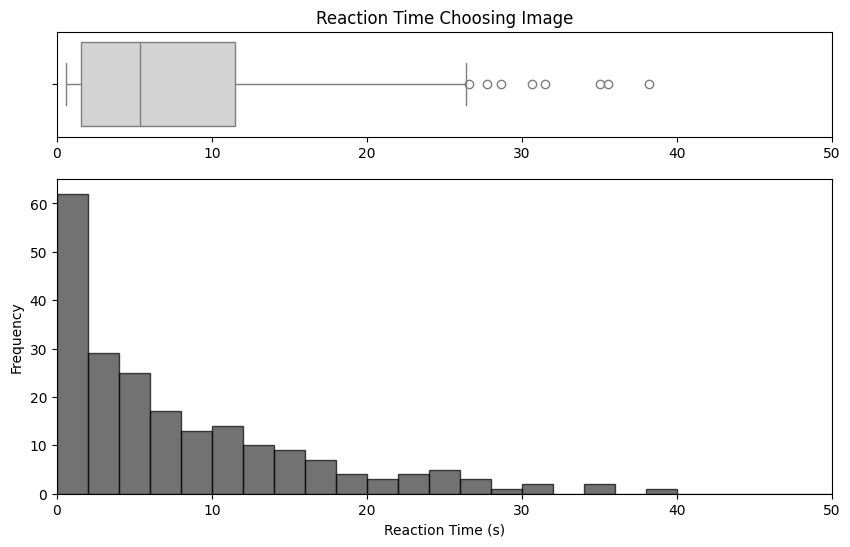

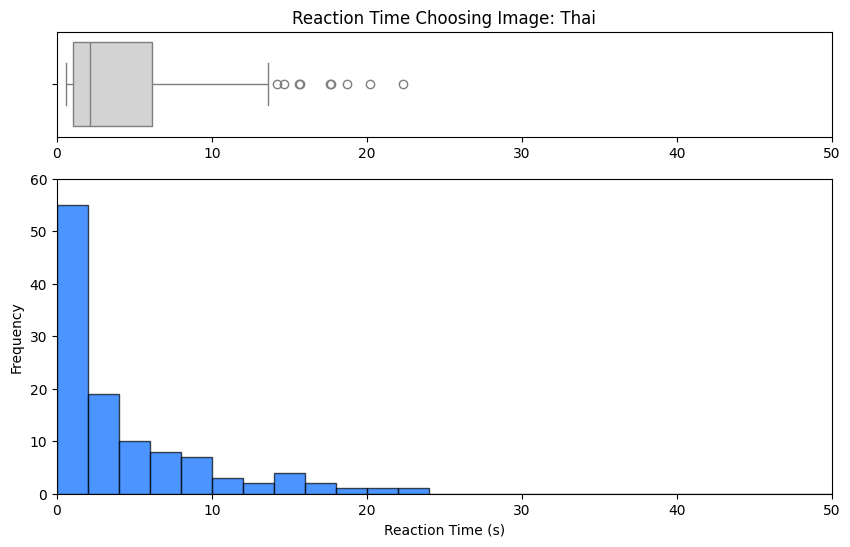

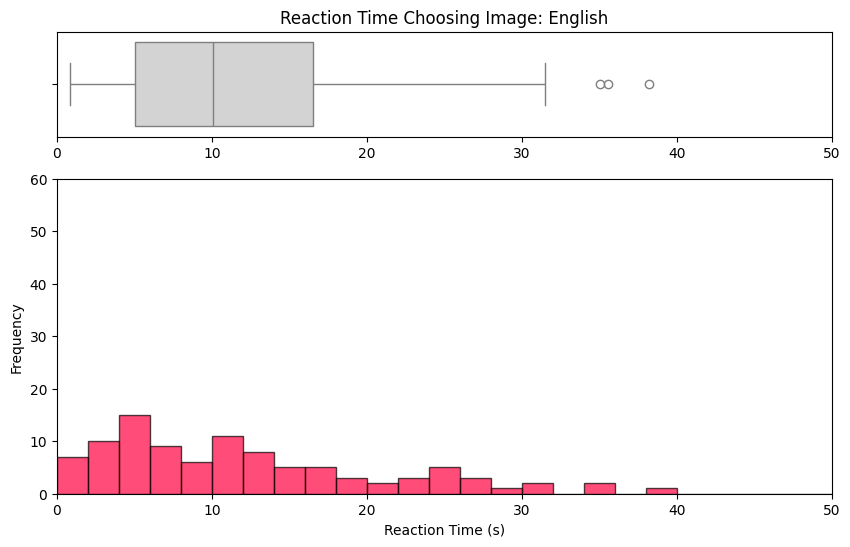

In [282]:
II_plot_RT_outliers(datafilter, '',"Reaction Time Choosing Image")
II_plot_RT_outliers(datafilter[datafilter['Language'] == 'Thai'], 'th',"Reaction Time Choosing Image: Thai", ylim=60)
II_plot_RT_outliers(datafilter[datafilter['Language'] == 'English'], 'en',"Reaction Time Choosing Image: English", ylim=60)

Language VS Reaction Time Histogram

# Word Length vs Reaction Time Graphs

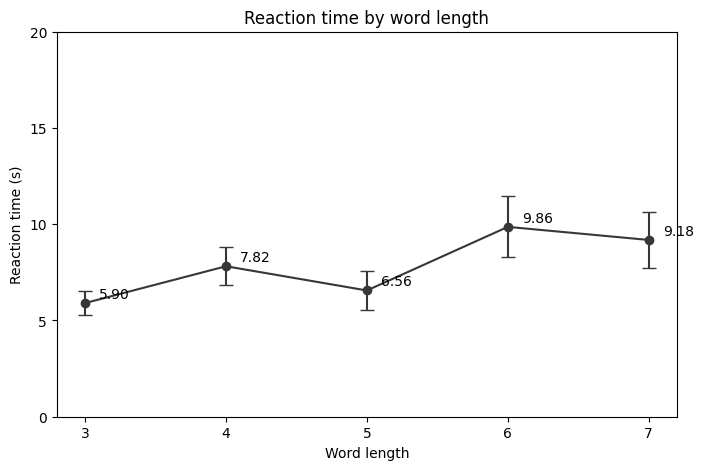

In [283]:
rtlen = datafilter.groupby('word_length')['key_resp.rt'].mean()
rterr = datafilter.groupby('word_length')['key_resp.rt'].sem()

plt.figure(figsize=(8, 5))
plt.errorbar(rtlen.index, rtlen.values, marker = 'o', color = gaygradient[4], yerr = rterr.values, capsize = 5)
for i in range(len(rtlen.index)):
    x = rtlen.index[i]
    y = rtlen.values[i]
    plt.text(x + 0.1, y + 0.1, f'{y:.2f}', ha='left', va='bottom', fontsize=10)

plt.title("Reaction time by word length")
plt.xlabel("Word length")
plt.xticks(rtlen.index)
plt.ylabel('Reaction time (s)')
plt.yticks(np.arange(0,21,5))
save_plot("Reaction time by word length")

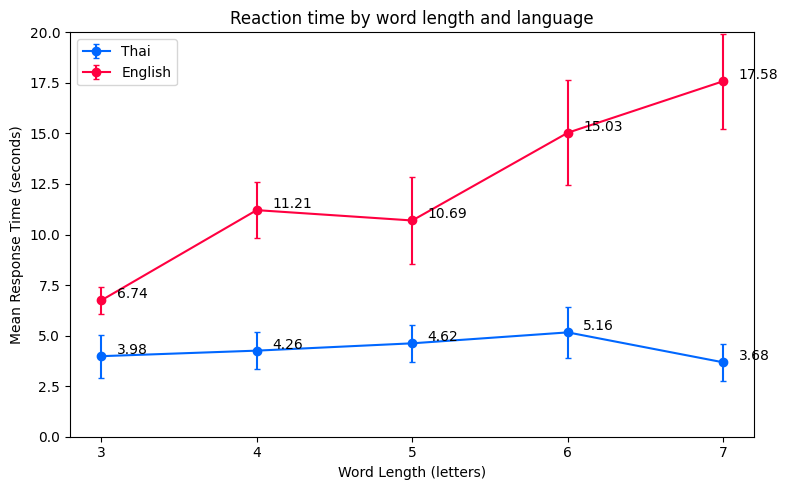

In [284]:

# Set the figure size and bar width
rtlen = datafilter.groupby(['word_length', 'Language'], observed=True)['key_resp.rt'].mean().unstack()
rterr = datafilter.groupby(['word_length', 'Language'], observed=True)['key_resp.rt'].sem().unstack()
rtlen = rtlen.loc[:, ['Thai', 'English']]
rterr = rterr.loc[:, ['Thai', 'English']]


plt.figure(figsize=(8, 5))  # Adjust the width and height here
for lang, sublist in rtlen.items():
    yerr = rterr[lang]
    colorchoice = bluegradient[4] if lang == 'Thai' else redgradient[4] if lang == 'English' else gaygradient[4]
     
    plt.errorbar(sublist.index, sublist.values, yerr = rterr[lang], capsize = 2, fmt = 'o-', color = colorchoice, label = lang)

    for i in range(0,len(sublist.index)):
        x = sublist.index[i]
        y = sublist.values[i]
        
        plt.text(x+0.1,y + 0.1,round(y, 2), ha = 'left')

plt.yticks(np.arange(0,21,5))


plt.xlabel('Word Length (letters)')
plt.ylabel('Mean Response Time (seconds)')
plt.title("Reaction time by word length and language")
plt.xticks(rtlen.index)
plt.ylim(0,20)
plt.yticks(np.arange(0,21,2.5))
plt.legend(loc = 'upper left')

# Save the plot to the specified directory
plt.tight_layout()
save_plot("Reaction time by word length and language")


# Stimuli Type vs Reaction Time Graphs

Language      Thai   English
stimuli                     
Correct   0.759755  1.733603
Scramble  0.667524  1.598915
Typo      0.887489  1.396211 <class 'pandas.core.frame.DataFrame'>
0 0.7597545365113939
1 0.6675243409033352
2 0.8874891705506798
0 1.733602656835424
1 1.598914703122659
2 1.396210999713023


C:\Users\UserPC\AppData\Local\Temp\ipykernel_13288\1121005170.py:40: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.arange(0,21,2.5))


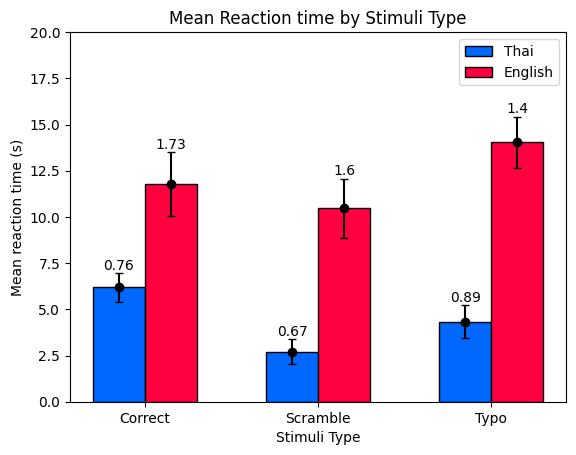

In [285]:
# Stimuli vs % correct
fig, ax = plt.subplots()

plot_data = datafilter.groupby(['stimuli', 'Language'], observed=True)['key_resp.rt'].mean().unstack()
plot_dataerr = datafilter.groupby(['stimuli', 'Language'], observed=True)['key_resp.rt'].sem().unstack()

custom_order = ['Thai', 'English']
plot_data = plot_data.reindex(columns=[col for col in custom_order if col in plot_data.columns])
plot_dataerr = plot_dataerr.reindex(columns=[col for col in custom_order if col in plot_data.columns])

print(plot_dataerr, type(plot_dataerr))

for i, (lang, sublist) in enumerate(plot_data.items()):
    x = np.arange(len(sublist.index)) + (i - 0.5) * width
    y = sublist.values
    colbylang = bluegradient[4] if lang == 'Thai' else redgradient[4] if lang == "English" else gaygradient[4]
    width = 0.3

    plt.bar(x, y, width = width, color = colbylang, edgecolor = 'black',label = lang)
    plt.errorbar(x, y, yerr = plot_dataerr[lang], fmt = 'o', color = 'black', capsize = 3)

    for i, err in enumerate(plot_dataerr[lang]):
        print(i, err)
        plt.text(x[i], y[i] + err + 0.2, round(err, 2), ha = 'center')



# Labels and title
ax.set_ylabel("Mean reaction time (s)")
ax.set_xlabel("Stimuli Type")
ax.set_xticks(np.arange(0,len(plot_data.index),1))
ax.set_xticklabels(plot_data.index.tolist())
ax.set_title("Mean Reaction time by Stimuli Type")

# Adjust legend position
ax.legend()

# Set y-axis limits
ax.set_ylim(0, 20)
ax.set_yticklabels(np.arange(0,21,2.5))
save_plot("Reaction time by stimuli")